# Subsetting climate variables over a watershed

Hydrological models are driven by precipitation, temperature and a number of other variables depending on the processes that are simulated. These variables are typically provided by networks of weather stations. For practicality, these point values are often interpolated over space to create *gridded products*, that is, arrays of climate variables over regular coordinates of time and space.

Global hydrological models however require time series of average climate variables over the entire watersheds. When the watershed includes multiples stations, or covers multiple grid cells, we first need to average these multiple stations or grids to yield a single value per time step. The Raven modeling framework can work directly with gridded datasets, provided the configuration includes the weights to apply to the array. For example, all grid cells outside the watershed could be given weights of 0, while all grid cells inside given a weight proportional to the area of the grid that is inside the watershed.

While there are now utilities to work with grid weights, it is usually more computationally efficient to feed Raven sub-watershed averages. Here we fetch a watershed outline from a geospatial data server, then use the Finch server to compute the watershed average.

In [1]:
# Import the necessary libraries.
import datetime as dt
import os

import birdy
import geopandas as gpd

In [2]:
# Set the links to the servers.
# Note that if Finch is a remote server, Raven needs to be accessible on the next because some cells
# below use the output from Raven processes to feed into Finch.

url_finch = os.environ.get(
    "FINCH_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/finch/wps"
)

url_raven = os.environ.get(
    "WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps"
)

# Establish client connexions to the remote servers
finch = birdy.WPSClient(url_finch)
raven = birdy.WPSClient(url_raven)

## Extracting the watershed contour and sub-basins identifiers

Let's try to identify a sub-basin feeding into Lake Kénogami. We'll start by launching a process with Raven to find the upstream watersheds. The process, called `hydrobasins_select`, takes as an input geographical point coordinates, finds the HydroSheds sub-basin including this point, then looks up into the HydroSheds database to find all upstream sub-basins. It returns the polygon of the watershed contour as a GeoJSON file, as well as a list of all the sub-basins IDs within the watershed.

In [3]:
# Send a request to the server and get the response.
hydrobasin_resp = raven.hydrobasins_select(
    location="-71.41, 47.96", aggregate_upstream=True
)

# Wait for the process to complete before continuing with calculations.

In [4]:
# Collecting the response: the watershed contour and the sub-basins ids
feature_url, sb_ids = hydrobasin_resp.get()
feature, subbasin_ids = hydrobasin_resp.get(asobj=True)

ERROR 1: PROJ: proj_create_from_database: Open of /home/tjs/mambaforge/envs/raven/share/proj failed


'Number of subbasins: 4'

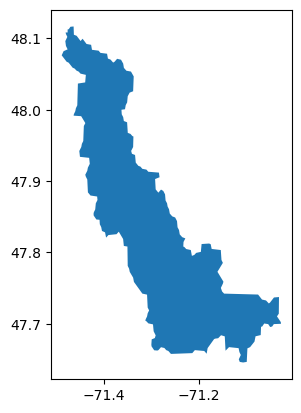

In [5]:
# Plot our vector shapefile
df = gpd.GeoDataFrame.from_file(feature_url)
df.plot()

display(f"Number of subbasins: {len(subbasin_ids)}")

## Subsetting a gridded climate dataset

We can then use this watershed outline to average climate data. The watershed shape is given as a GeoJSON file to the `average_polygon` process, along with the gridded file to average.

In [6]:
# Compute the watershed temperature average.
nc_file = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/testdata/xclim/NRCANdaily/nrcan_canada_daily_tasmin_1990.nc"

resp = finch.average_polygon(
    resource=str(nc_file),
    shape=feature_url,
    tolerance=0.1,
    start_date=dt.datetime(1990, 5, 1),
    end_date=dt.datetime(1990, 9, 1),
)

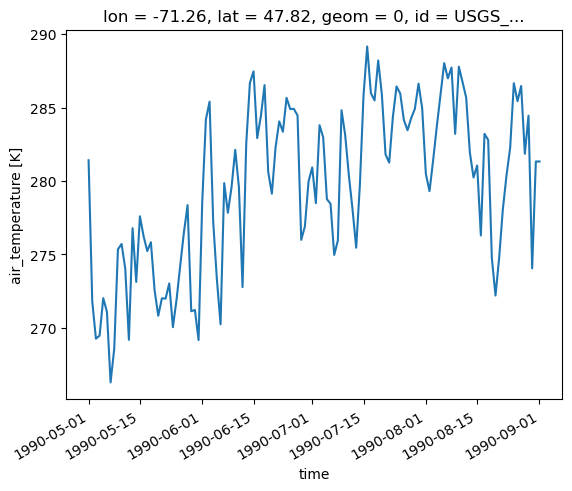

In [7]:
# Get the output files and plot the temperature time series averaged over the sub-basins.
ds, meta = resp.get(asobj=True)
ds.tasmin.plot()
